In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
import os

In [ ]:
os.chdir('/content/drive/MyDrive/Javiera_Research')

In [ ]:
!ls

 cleaned_data  'General presentation.gslides'   notebooks


In [ ]:
!ls cleaned_data/

brain_56cols_kmeans4.csv
brain_56cols_kmeans4_filtered.csv
Codings.csv
cols_deleted.txt
df_cluster_encoded.csv
df_result_base.csv
df_result_grid.csv
fil_1yr_53cols_pos_all.csv
fil_1yr_53cols_pos_mixed.csv
fil_1yr_64cols_pos_mixed.csv
fil_1yr_66cols_pos_mixed.csv
fil_1yr_correlation_cols_pos_all.csv
fil_columns.txt
javie_filtered_cols.csv
kmeans_grid_dict.json
kmedoids_grid_dict.json
og_columns.txt
ukb43673_57cols.csv
ukb43673_61cols_1yr.csv
ukb43673_72cols.csv
ukb43673_74cols_1yr.csv
ukb43673_74cols_6mo.csv
ukb43673_76cols_1yr.csv
ukb43673_brain_56cols_1yr.csv
ukb43673_correlation_cols_1yr.csv
ukb_response_impute_ref_stats_group_ds3.csv


# Imports

In [ ]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import matplotlib.cm as cm
import matplotlib.animation as animation
import datetime
from dateutil.relativedelta import relativedelta

import imblearn

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import sklearn.metrics as skm
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# import gower

# setup linear tqdm
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# load data

In [ ]:
df_og = pd.read_csv('cleaned_data/df_result_grid.csv')
  # this is the original questionnaire df after filter out -818 and -121 rows in all columns, both ordinal and numerical
  # appended with the clustering results for different k
  # should have shape (5772,73)
df_og

,eid,31-0.0,53-2.0,20400-0.0,20458-0.0,20459-0.0,20460-0.0,20479-0.0,20485-0.0,20495-0.0,20497-0.0,20498-0.0,20505-0.0,20506-0.0,20507-0.0,20508-0.0,20509-0.0,20510-0.0,20511-0.0,20512-0.0,20513-0.0,20514-0.0,20515-0.0,20516-0.0,20517-0.0,20518-0.0,20519-0.0,20520-0.0,21003-2.0,21023-0.0,21025-0.0,21033-0.0,21034-0.0,21040-0.0,21041-0.0,21042-0.0,21043-0.0,21044-0.0,21048-0.0,21049-0.0,21051-0.0,21052-0.0,21053-0.0,21054-0.0,21055-0.0,21056-0.0,21057-0.0,21058-0.0,21059-0.0,21060-0.0,21061-0.0,center2_time_lapse1,center2_time_lapse2,kmedoid_cluster_13,kmedoid_cluster_12,kmedoid_cluster_11,kmedoid_cluster_10,kmedoid_cluster_9,kmedoid_cluster_8,kmedoid_cluster_7,kmedoid_cluster_6,kmedoid_cluster_5,kmedoid_cluster_4,kmeans_cluster_13,kmeans_cluster_12,kmeans_cluster_11,kmeans_cluster_10,kmeans_cluster_9,kmeans_cluster_8,kmeans_cluster_7,kmeans_cluster_6,kmeans_cluster_5,kmeans_cluster_4
0,1000993,1.0,2017-06-21,2016-07-28,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,59.0,2017-04-11,0.0,-500.0,-501.0,1.0,0.0,3.0,5.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,328 days,71 days,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1001367,1.0,2017-08-16,2016-09-30,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,78.0,2017-08-24,4.0,-503.0,-501.0,8.0,0.0,1.0,7.0,1.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,320 days,-8 days,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1003110,1.0,2016-05-25,2016-08-18,2.0,3.0,3.0,2.0,1.0,1.0,0.0,0.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,2.0,64.0,2017-04-28,0.0,-500.0,-501.0,1.0,0.0,2.0,6.0,1.0,-600.0,-602.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-85 days,-338 days,3.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1003823,1.0,2016-05-31,2016-08-24,2.0,1.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,59.0,2017-05-05,0.0,-501.0,-500.0,1.0,2.0,2.0,3.0,1.0,-600.0,-601.0,-601.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-601.0,-601.0,-85 days,-339 days,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0,1.0,1.0,3.0,1.0
4,1004315,0.0,2017-09-15,2017-04-25,4.0,5.0,3.0,2.0,2.0,0.0,0.0,0.0,3.0,2.0,4.0,1.0,2.0,3.0,1.0,2.0,2.0,3.0,2.0,1.0,3.0,1.0,3.0,2.0,53.0,2017-04-25,3.0,-500.0,-501.0,1.0,1.0,2.0,5.0,1.0,-601.0,-600.0,-600.0,-600.0,-601.0,-600.0,-601.0,-601.0,-313.0,-600.0,-601.0,-602.0,-601.0,143 days,143 days,5.0,5.0,5.0,5.0,5.0,5.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5767,6021110,1.0,2016-07-25,2016-08-19,3.0,3.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.0,2017-05-04,1.0,-500.0,-500.0,1.0,0.0,3.0,1.0,2.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-313.0,-600.0,-600.0,-600.0,-600.0,-25 days,-283 days,7.0,12.0,11.0,10.0,2.0,2.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5768,6022430,1.0,2016-12-18,2016-12-12,1.0,2.0,5.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,61.0,2017-04-28,0.0,-500.0,-500.0,2.0,0.0,2.0,7.0,1.0,-600.0,-601.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-600.0,-602.0,-600.0,-600.0,-601.0,6 days,-131 days,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0,1.0,1.0,7.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5769,6022902,1.0,2017-09-09,2016-09-22,2.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,61.0,2017-05-20,5.0,-501.0,-501.0,2.0,

In [ ]:
# keep only the eid column and the k=4 kmeans column to match with the brain data
df_temp = df_og[['eid','kmeans_cluster_4']]

In [ ]:
df_brain = pd.read_csv('cleaned_data/ukb43673_brain_56cols_1yr.csv')
  # this is the original brain df after keeping only the columns Javi listed and only the rows matching the 'eid' of only 1yr gaps
  # should have shape (6287 ,56)
df_brain

,eid,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
0,1000993,7731.0,7798.0,3910.0,4245.0,1481.0,1323.0,0.517769,0.519163,0.001549,0.000852,0.000800,0.573230,0.484127,0.334499,0.233358,0.534040,0.502791,0.413865,0.450672,0.381691,0.383235,0.000764,0.000764,0.000835,0.000943,0.000733,0.000734,0.000893,0.000890,0.000778,0.000802,20470.5,24125.0,5684.64,5820.36,1461.89,1565.00,4495.84,3917.27,4807.41,4796.22,4802.13,4924.80,2712.32,2696.50,1710.89,1691.51,1429.820,1287.030,3145.17,3160.96,4046.24,4464.16,1750.55,2023.10
1,1001367,7712.0,7561.0,2717.0,2798.0,812.0,1438.0,0.517108,0.530976,0.001884,0.000915,0.000860,0.448087,0.473721,0.344920,0.318257,0.532078,0.521686,0.438471,0.452258,0.392484,0.400138,0.000797,0.000785,0.000928,0.001066,0.000774,0.000798,0.000896,0.000892,0.000844,0.000844,23636.6,27566.5,5570.03,5236.93,1773.16,1362.06,3648.68,5816.66,5288.24,5675.30,6308.72,5433.23,3097.14,3154.24,1502.23,1268.06,833.469,1054.980,2786.42,2908.76,4114.25,3344.82,1962.76,1933.99
2,1003110,NaN,NaN,NaN,NaN,NaN,NaN,0.515724,0.484649,0.001474,0.000866,0.000869,0.531748,0.504692,0.316218,0.314996,0.548032,0.531419,0.423061,0.387133,0.362997,0.366122,0.000769,0.000771,0.000877,0.000905,0.000758,0.000776,0.000907,0.000929,0.000829,0.000843,21736.8,25180.0,6473.89,6883.81,1395.98,1444.92,4326.74,5068.76,5540.58,5670.42,6999.42,6313.67,2789.37,3560.78,1717.28,1383.63,1482.760,1198.490,2597.30,2759.24,4548.14,5094.23,2141.57,2364.66
3,1003668,9348.0,9322.0,4973.0,5218.0,1003.0,1694.0,0.565118,0.563306,0.001107,0.000813,0.000837,0.568728,0.546719,0.344964,0.339941,0.566609,0.567653,0.433444,0.440910,0.444479,0.420357,0.000761,0.000744,0.000805,0.000839,0.000758,0.000763,0.000866,0.000895,0.000740,0.000744,26738.3,30505.6,6917.96,6766.75,2706.68,2790.60,5307.60,5310.91,5830.16,5748.91,7714.26,7165.02,3580.95,3988.04,2018.60,1573.53,1782.870,1624.730,2728.45,2949.75,5222.12,5341.69,2506.20,2785.57
4,1003823,9106.0,8354.0,3648.0,4132.0,1427.0,1598.0,0.565555,0.531572,0.001712,0.000833,0.000832,0.502904,0.456817,0.342519,0.339688,0.562325,0.562203,0.477598,0.473553,0.383220,0.388729,0.000767,0.000767,0.000889,0.000852,0.000797,0.000775,0.000843,0.000850,0.000833,0.000827,30973.8,31256.4,6835.57,7250.09,2454.37,1786.52,6855.68,6856.05,7546.45,7305.91,8784.31,8619.36,3227.70,2934.48,1597.97,1450.46,1437.600,1474.350,2980.77,3193.36,4215.36,4552.72,1968.82,2229.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6282,6021110,8437.0,8315.0,4418.0,4572.0,1023.0,1439.0,0.525815,0.527737,0.001491,0.000846,0.000877,0.523399,0.502088,0.291354,0.315926,0.541859,0.543817,0.440840,0.426501,0.406707,0.411986,0.000764,0.000758,0.000888,0.000866,0.000770,0.000773,0.000911,0.000929,0.000780,0.000780,25292.6,30452.3,6844.96,6869.69,2455.27,2327.11,4599.56,5716.81,6609.43,7018.91,7729.63,7073.29,2686.76,3132.17,2190.75,1491.06,1837.540,1142.600,2634.73,2791.85,4734.81,4616.08,2015.03,2285.03
6283,6022430,8719.0,8696.0,3783.0,4457.0,1232.0,1103.0,0.559929,0.543902,0.001473,0.000861,0.000830,0.526542,0.521600,0.371121,0.348886,0.545633,0.535560,0.412591,0.410387,0.372528,0.369844,0.000776,0.000769,0.000827,0.000866,0.000785,0.000792,0.000931,0.000892,0.000814,0.000831,24700.5,27232.6,7218.52,7201.46,1952.68,1436.59,5615.63,6577.97,5403.41,5445.32,6675.56,6964.40,2976.54,3126.36,1934.18,1320.40,

In [ ]:
df = df_temp.merge(df_brain, how='left', on='eid')
  # should have shape (5772,57)
print(df.shape)
df.set_index('eid',inplace=True)
  # set the column 'eid' as index
df

(5772, 57)


,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
eid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000993,1.0,7731.0,7798.0,3910.0,4245.0,1481.0,1323.0,0.517769,0.519163,0.001549,0.000852,0.000800,0.573230,0.484127,0.334499,0.233358,0.534040,0.502791,0.413865,0.450672,0.381691,0.383235,0.000764,0.000764,0.000835,0.000943,0.000733,0.000734,0.000893,0.000890,0.000778,0.000802,20470.5,24125.0,5684.64,5820.36,1461.89,1565.00,4495.84,3917.27,4807.41,4796.22,4802.13,4924.80,2712.32,2696.50,1710.89,1691.51,1429.820,1287.030,3145.17,3160.96,4046.24,4464.16,1750.55,2023.10
1001367,1.0,7712.0,7561.0,2717.0,2798.0,812.0,1438.0,0.517108,0.530976,0.001884,0.000915,0.000860,0.448087,0.473721,0.344920,0.318257,0.532078,0.521686,0.438471,0.452258,0.392484,0.400138,0.000797,0.000785,0.000928,0.001066,0.000774,0.000798,0.000896,0.000892,0.000844,0.000844,23636.6,27566.5,5570.03,5236.93,1773.16,1362.06,3648.68,5816.66,5288.24,5675.30,6308.72,5433.23,3097.14,3154.24,1502.23,1268.06,833.469,1054.980,2786.42,2908.76,4114.25,3344.82,1962.76,1933.99
1003110,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.515724,0.484649,0.001474,0.000866,0.000869,0.531748,0.504692,0.316218,0.314996,0.548032,0.531419,0.423061,0.387133,0.362997,0.366122,0.000769,0.000771,0.000877,0.000905,0.000758,0.000776,0.000907,0.000929,0.000829,0.000843,21736.8,25180.0,6473.89,6883.81,1395.98,1444.92,4326.74,5068.76,5540.58,5670.42,6999.42,6313.67,2789.37,3560.78,1717.28,1383.63,1482.760,1198.490,2597.30,2759.24,4548.14,5094.23,2141.57,2364.66
1003823,1.0,9106.0,8354.0,3648.0,4132.0,1427.0,1598.0,0.565555,0.531572,0.001712,0.000833,0.000832,0.502904,0.456817,0.342519,0.339688,0.562325,0.562203,0.477598,0.473553,0.383220,0.388729,0.000767,0.000767,0.000889,0.000852,0.000797,0.000775,0.000843,0.000850,0.000833,0.000827,30973.8,31256.4,6835.57,7250.09,2454.37,1786.52,6855.68,6856.05,7546.45,7305.91,8784.31,8619.36,3227.70,2934.48,1597.97,1450.46,1437.600,1474.350,2980.77,3193.36,4215.36,4552.72,1968.82,2229.03
1004315,3.0,7774.0,7386.0,3662.0,3993.0,1419.0,1154.0,0.576219,0.592066,0.001249,0.000832,0.000795,0.557935,0.518180,0.331406,0.285294,0.550688,0.540415,0.443497,0.425165,0.400163,0.403540,0.000710,0.000734,0.000792,0.000837,0.000770,0.000788,0.000863,0.000898,0.000743,0.000750,23035.5,27176.8,6192.51,6100.30,1989.57,2095.65,3819.54,5083.01,4094.86,4470.47,6385.11,5952.27,2348.40,2268.51,1864.38,1367.66,1831.850,1502.120,2645.42,2665.90,4192.30,4237.17,1914.12,2132.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021110,1.0,8437.0,8315.0,4418.0,4572.0,1023.0,1439.0,0.525815,0.527737,0.001491,0.000846,0.000877,0.523399,0.502088,0.291354,0.315926,0.541859,0.543817,0.440840,0.426501,0.406707,0.411986,0.000764,0.000758,0.000888,0.000866,0.000770,0.000773,0.000911,0.000929,0.000780,0.000780,25292.6,30452.3,6844.96,6869.69,2455.27,2327.11,4599.56,5716.81,6609.43,7018.91,7729.63,7073.29,2686.76,3132.17,2190.75,1491.06,1837.540,1142.600,2634.73,2791.85,4734.81,4616.08,2015.03,2285.03
6022430,1.0,8719.0,8696.0,3783.0,4457.0,1232.0,1103.0,0.559929,0.543902,0.001473,0.000861,0.000830,0.526542,0.521600,0.371121,0.348886,0.545633,0.535560,0.412591,0.410387,0.372528,0.369844,0.000776,0.000769,0.000827,0.000866,0.000785,0.000792,0.000931,0.000892,0.000814,0.000831,24700.5,27232.6,7218.52,7201.46,1952.68,1436.59

In [ ]:
df.to_csv('cleaned_data/brain_56cols_kmeans4.csv', index=True)

# EDA

In [ ]:
df = pd.read_csv('cleaned_data/brain_56cols_kmeans4.csv')
df.set_index('eid', inplace=True)

In [ ]:
# look at how many samples we have for each class
df.groupby('kmeans_cluster_4')['25011-2.0'].count()

kmeans_cluster_4
1.0    2404
2.0     756
3.0     442
4.0    1466
Name: 25011-2.0, dtype: int64

Text(0.5, 1.0, 'before cleaning')

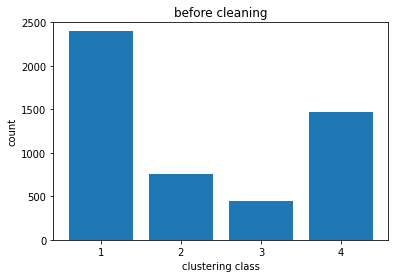

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(x = [1,2,3,4], height=df.groupby('kmeans_cluster_4')['25011-2.0'].count(), 
        tick_label = ['1','2','3','4'])
plt.xlabel('clustering class')
plt.ylabel('count')
plt.ylim(top=2500)
plt.title('before cleaning')

In [ ]:
df.describe()

,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
count,5772.000000,5068.000000,5068.000000,5068.000000,5068.000000,5068.000000,5068.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.00000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000,5070.000000
mean,2.181566,7763.553473,7570.385359,3801.083465,3909.691594,1271.991121,1239.436661,0.524366,0.523395,0.001561,0.000874,0.000853,0.532474,0.496324,0.311007,0.309912,0.543659,0.537365,0.418014,0.420711,0.388427,0.388347,0.000763,0.000765,0.000883,0.000896,0.000777,0.000780,0.000905,0.000906,0.000805,0.000804,23174.666174,26151.757751,6278.160941,6265.546219,1895.970170,1894.811728,5103.741718,5645.785318,5207.057933,5449.052363,6624.276039,6027.91540,2942.900014,3005.211012,1700.727767,1377.187108,1504.119419,1336.366981,2695.365464,2825.958659,4209.221974,4370.774207,1818.229889,2088.576937
std,1.294037,742.029312,727.776683,471.023065,488.266876,245.435667,269.280285,0.036014,0.037854,0.000310,0.000064,0.000060,0.033069,0.033264,0.030184,0.032553,0.023312,0.024061,0.023261,0.024042,0.022865,0.020546,0.000026,0.000026,0.000063,0.000065,0.000027,0.000027,0.000043,0.000042,0.000038,0.000033,2736.051894,3065.049244,672.314627,672.299052,319.820078,326.150003,1081.223152,1207.758279,769.962636,783.199765,847.410492,761.77892,428.167691,460.383902,216.741622,177.361623,258.832068,243.158818,303.711632,317.228958,417.695018,432.845142,230.258830,259.937722
min,1.000000,5297.000000,5249.000000,1583.000000,1390.000000,455.000000,384.000000,0.250751,0.254980,0.000967,0.000706,0.000688,0.388355,0.376377,0.172164,0.171699,0.000000,0.000000,0.331509,0.325727,0.234679,0.259762,0.000602,0.000609,0.000741,0.000731,0.000000,0.000000,0.000759,0.000731,0.000677,0.000698,14835.000000,16707.700000,4166.380000,3345.470000,799.860000,939.530000,2611.260000,2552.770000,3188.950000,3465.980000,4027.670000,3389.33000,1699.880000,1655.290000,1015.050000,831.400000,726.011000,641.211000,1862.260000,1957.340000,2679.020000,2882.070000,843.039000,1173.260000
25%,1.000000,7246.000000,7064.750000,3510.000000,3614.000000,1109.000000,1065.000000,0.502996,0.500115,0.001350,0.000835,0.000817,0.510195,0.473691,0.295542,0.293685,0.529709,0.523093,0.403177,0.405119,0.373443,0.374954,0.000746,0.000748,0.000844,0.000856,0.000760,0.000764,0.000877,0.000879,0.000779,0.000782,21244.150000,24024.975000,5803.710000,5801.725000,1667.402500,1661.075000,4383.492500,4841.005000,4680.477500,4902.005000,6040.160000,5499.40250,2645.002500,2679.295000,1551.255000,1257.140000,1321.335000,1162.540000,2500.290000,2626.590000,3923.055000,4075.857500,1665.602500,1922.577500
50%,2.000000,7734.000000,7532.000000,3807.000000,3913.500000,1266.000000,1242.000000,0.526312,0.526452,0.001498,0.000865,0.000845,0.533537,0.496856,0.313777,0.312505,0.544628,0.538294,0.418099,0.420840,0.388555,0.388397,0.000762,0.000764,0.000873,0.000887,0.000775,0.000779,0.000903,0.000905,0.000802,0.000802,23010.900000,25955.200000,6245.205000,6219.245000,1882.960000,1874.695000,4941.98500

In [ ]:
df.isnull().sum()

kmeans_cluster_4       0
25011-2.0            704
25012-2.0            704
25019-2.0            704
25020-2.0            704
25021-2.0            704
25022-2.0            704
25094-2.0           1215
25095-2.0           1215
25109-2.0           1215
25142-2.0           1215
25143-2.0           1215
25492-2.0           1215
25493-2.0           1215
25494-2.0           1215
25495-2.0           1215
25496-2.0           1215
25497-2.0           1215
25505-2.0           1215
25506-2.0           1215
25513-2.0           1215
25514-2.0           1215
25519-2.0           1215
25520-2.0           1215
25521-2.0           1215
25522-2.0           1215
25523-2.0           1215
25524-2.0           1215
25532-2.0           1215
25533-2.0           1215
25540-2.0           1215
25541-2.0           1215
25782-2.0            702
25783-2.0            702
25784-2.0            702
25785-2.0            702
25830-2.0            702
25831-2.0            702
25838-2.0            702
25839-2.0            702


# remove missing values

In [ ]:
df_fil = df.copy()
df_fil.dropna(axis='index', how='any',inplace=True)
  # drop rows that have ANY missing values
df_fil

,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
eid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000993,1.0,7731.0,7798.0,3910.0,4245.0,1481.0,1323.0,0.517769,0.519163,0.001549,0.000852,0.000800,0.573230,0.484127,0.334499,0.233358,0.534040,0.502791,0.413865,0.450672,0.381691,0.383235,0.000764,0.000764,0.000835,0.000943,0.000733,0.000734,0.000893,0.000890,0.000778,0.000802,20470.5,24125.0,5684.64,5820.36,1461.89,1565.00,4495.84,3917.27,4807.41,4796.22,4802.13,4924.80,2712.32,2696.50,1710.89,1691.51,1429.820,1287.030,3145.17,3160.96,4046.24,4464.16,1750.55,2023.10
1001367,1.0,7712.0,7561.0,2717.0,2798.0,812.0,1438.0,0.517108,0.530976,0.001884,0.000915,0.000860,0.448087,0.473721,0.344920,0.318257,0.532078,0.521686,0.438471,0.452258,0.392484,0.400138,0.000797,0.000785,0.000928,0.001066,0.000774,0.000798,0.000896,0.000892,0.000844,0.000844,23636.6,27566.5,5570.03,5236.93,1773.16,1362.06,3648.68,5816.66,5288.24,5675.30,6308.72,5433.23,3097.14,3154.24,1502.23,1268.06,833.469,1054.980,2786.42,2908.76,4114.25,3344.82,1962.76,1933.99
1003823,1.0,9106.0,8354.0,3648.0,4132.0,1427.0,1598.0,0.565555,0.531572,0.001712,0.000833,0.000832,0.502904,0.456817,0.342519,0.339688,0.562325,0.562203,0.477598,0.473553,0.383220,0.388729,0.000767,0.000767,0.000889,0.000852,0.000797,0.000775,0.000843,0.000850,0.000833,0.000827,30973.8,31256.4,6835.57,7250.09,2454.37,1786.52,6855.68,6856.05,7546.45,7305.91,8784.31,8619.36,3227.70,2934.48,1597.97,1450.46,1437.600,1474.350,2980.77,3193.36,4215.36,4552.72,1968.82,2229.03
1004315,3.0,7774.0,7386.0,3662.0,3993.0,1419.0,1154.0,0.576219,0.592066,0.001249,0.000832,0.000795,0.557935,0.518180,0.331406,0.285294,0.550688,0.540415,0.443497,0.425165,0.400163,0.403540,0.000710,0.000734,0.000792,0.000837,0.000770,0.000788,0.000863,0.000898,0.000743,0.000750,23035.5,27176.8,6192.51,6100.30,1989.57,2095.65,3819.54,5083.01,4094.86,4470.47,6385.11,5952.27,2348.40,2268.51,1864.38,1367.66,1831.850,1502.120,2645.42,2665.90,4192.30,4237.17,1914.12,2132.89
1004449,1.0,7523.0,7673.0,2610.0,3705.0,1316.0,1508.0,0.594285,0.555879,0.001604,0.000782,0.000765,0.577567,0.480762,0.331424,0.353024,0.583016,0.579894,0.446387,0.438818,0.404958,0.400107,0.000745,0.000744,0.000844,0.000884,0.000764,0.000781,0.000889,0.000929,0.000781,0.000787,24366.2,27856.2,6587.04,6444.35,2118.58,1996.07,5865.49,7130.06,6526.02,5818.52,7316.77,6460.84,2892.63,2914.22,1350.34,1224.34,1498.140,1497.800,2519.22,2432.88,3369.10,4056.99,1993.78,2184.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021110,1.0,8437.0,8315.0,4418.0,4572.0,1023.0,1439.0,0.525815,0.527737,0.001491,0.000846,0.000877,0.523399,0.502088,0.291354,0.315926,0.541859,0.543817,0.440840,0.426501,0.406707,0.411986,0.000764,0.000758,0.000888,0.000866,0.000770,0.000773,0.000911,0.000929,0.000780,0.000780,25292.6,30452.3,6844.96,6869.69,2455.27,2327.11,4599.56,5716.81,6609.43,7018.91,7729.63,7073.29,2686.76,3132.17,2190.75,1491.06,1837.540,1142.600,2634.73,2791.85,4734.81,4616.08,2015.03,2285.03
6022430,1.0,8719.0,8696.0,3783.0,4457.0,1232.0,1103.0,0.559929,0.543902,0.001473,0.000861,0.000830,0.526542,0.521600,0.371121,0.348886,0.545633,0.535560,0.412591,0.410387,0.372528,0.369844,0.000776,0.000769,0.000827,0.000866,0.000785,0.000792,0.000931,0.000892,0.000814,0.000831,24700.5,27232.6,7218.52,7201.

In [ ]:
# look at how many samples we have for each class after cleaning
df_fil.groupby('kmeans_cluster_4')['25011-2.0'].count()

kmeans_cluster_4
1.0    2184
2.0     668
3.0     398
4.0    1305
Name: 25011-2.0, dtype: int64

Text(0.5, 1.0, 'after cleaning')

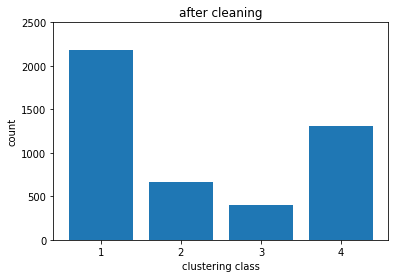

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(x = [1,2,3,4], height=df_fil.groupby('kmeans_cluster_4')['25011-2.0'].count(), 
        tick_label = ['1','2','3','4'])
plt.xlabel('clustering class')
plt.ylabel('count')
plt.ylim(top=2500)
  # put it on the same scale as the original
plt.title('after cleaning')

In [ ]:
df_fil.describe()

,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
count,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.00000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000,4555.000000
mean,2.180900,7764.724918,7571.417783,3802.670252,3914.138090,1270.709989,1239.553238,0.524376,0.523406,0.001561,0.000874,0.000852,0.532484,0.496342,0.311001,0.309904,0.543669,0.537384,0.418020,0.420732,0.388437,0.388359,0.000763,0.000765,0.000883,0.000896,0.000777,0.000780,0.000905,0.000906,0.000805,0.000804,23185.535038,26162.033787,6280.231370,6268.746514,1898.017816,1896.686858,5097.048046,5638.154472,5208.060364,5451.159377,6629.600885,6028.786121,2944.606753,3007.230083,1701.572371,1378.497668,1505.79771,1337.782781,2692.148356,2822.626764,4211.649014,4373.089186,1820.946180,2091.018318
std,1.296336,743.531793,727.822184,473.665141,487.827036,244.981215,268.972889,0.036017,0.037858,0.000310,0.000064,0.000060,0.033070,0.033243,0.030189,0.032557,0.023306,0.024038,0.023260,0.024024,0.022865,0.020542,0.000026,0.000026,0.000063,0.000065,0.000027,0.000027,0.000043,0.000042,0.000038,0.000033,2730.602185,3054.287653,672.776809,672.815741,318.034507,324.892095,1075.446388,1207.384362,771.523366,787.648728,856.919357,765.935729,426.371068,461.052606,217.547754,176.924742,256.69283,242.473509,303.631755,317.291791,418.134052,432.385187,230.499337,260.473708
min,1.000000,5396.000000,5329.000000,1583.000000,1390.000000,455.000000,384.000000,0.250751,0.254980,0.000967,0.000706,0.000688,0.388355,0.376377,0.172164,0.171699,0.000000,0.000000,0.331509,0.325727,0.234679,0.259762,0.000602,0.000609,0.000741,0.000731,0.000000,0.000000,0.000759,0.000731,0.000677,0.000698,14933.500000,16888.700000,4166.380000,3345.470000,799.860000,939.530000,2611.260000,2552.770000,3188.950000,3465.980000,4027.670000,3389.330000,1699.880000,1655.290000,1015.050000,831.400000,726.01100,641.211000,1862.260000,1957.340000,2679.020000,2882.070000,994.659000,1173.260000
25%,1.000000,7242.000000,7062.000000,3508.000000,3615.500000,1110.000000,1064.500000,0.503007,0.500129,0.001350,0.000835,0.000817,0.510209,0.473695,0.295522,0.293670,0.529713,0.523108,0.403192,0.405144,0.373448,0.374970,0.000746,0.000748,0.000844,0.000856,0.000760,0.000764,0.000877,0.000879,0.000779,0.000782,21243.150000,24023.500000,5803.210000,5801.210000,1670.005000,1662.445000,4383.605000,4831.335000,4674.845000,4891.390000,6035.910000,5497.350000,2645.045000,2683.085000,1551.795000,1258.350000,1325.96500,1164.865000,2497.690000,2623.220000,3923.830000,4076.790000,1666.675000,1924.080000
50%,2.000000,7732.000000,7532.000000,3807.000000,3920.000000,1263.000000,1242.000000,0.526314,0.526484,0.001498,0.000865,0.000845,0.533538,0.496856,0.313775,0.312488,0.544628,0.538298,0.418099,0.420899,0.388555,0.388402,0.000762,0.000764,0.000873,0.000887,0.000775,0.000779,0.000903,0.000905,0.000802,0.000802,23023.800000,25964.600000,6248.340000,6220.030000,1883.580000,1875.540000,4936.28000

In [ ]:
df_fil.isnull().sum().sum()

0

In [ ]:
5772-4555

1217

In [ ]:
df_fil.to_csv('cleaned_data/brain_56cols_kmeans4_filtered.csv', index=True)

# train test split

In [ ]:
df_fil = pd.read_csv('cleaned_data/brain_56cols_kmeans4_filtered.csv')
df_fil.set_index('eid', inplace=True)

In [ ]:
train, test = train_test_split(df_fil, test_size=0.25, random_state=42, stratify=df_fil['kmeans_cluster_4'])
  # stratify against the target column so both train and test have the same proportion of classes

In [ ]:
print(train.shape)
print(test.shape)

(3416, 56)
(1139, 56)


Text(0.5, 0.98, 'distributions of classes after split')

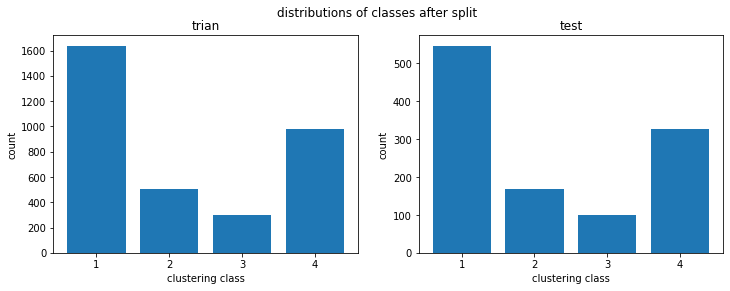

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].bar(x = [1,2,3,4], height=train.groupby('kmeans_cluster_4')['25011-2.0'].count(), 
        tick_label = ['1','2','3','4'])
ax[0].set_xlabel('clustering class')
ax[0].set_ylabel('count')
# ax[0].set_ylim(top=2000)
  # put it on the same scale as the original
ax[0].set_title('trian')

ax[1].bar(x = [1,2,3,4], height=test.groupby('kmeans_cluster_4')['25011-2.0'].count(), 
        tick_label = ['1','2','3','4'])
ax[1].set_xlabel('clustering class')
ax[1].set_ylabel('count')
# ax[1].set_ylim(top=2500)
  # put it on the same scale as the original
ax[1].set_title('test')
fig.suptitle('distributions of classes after split')

In [ ]:
train

,kmeans_cluster_4,25011-2.0,25012-2.0,25019-2.0,25020-2.0,25021-2.0,25022-2.0,25094-2.0,25095-2.0,25109-2.0,25142-2.0,25143-2.0,25492-2.0,25493-2.0,25494-2.0,25495-2.0,25496-2.0,25497-2.0,25505-2.0,25506-2.0,25513-2.0,25514-2.0,25519-2.0,25520-2.0,25521-2.0,25522-2.0,25523-2.0,25524-2.0,25532-2.0,25533-2.0,25540-2.0,25541-2.0,25782-2.0,25783-2.0,25784-2.0,25785-2.0,25830-2.0,25831-2.0,25838-2.0,25839-2.0,25840-2.0,25841-2.0,25846-2.0,25847-2.0,25848-2.0,25849-2.0,25850-2.0,25851-2.0,25862-2.0,25863-2.0,25878-2.0,25879-2.0,25886-2.0,25887-2.0,25888-2.0,25889-2.0
eid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1627366,1.0,8415.0,8092.0,3685.0,4372.0,1640.0,1863.0,0.536798,0.527825,0.002131,0.000980,0.000925,0.579273,0.518401,0.360385,0.353407,0.587675,0.580737,0.414336,0.410954,0.416963,0.410469,0.000730,0.000714,0.000855,0.000959,0.000746,0.000768,0.000941,0.000977,0.000806,0.000779,23236.0,25527.2,6587.74,6724.84,1854.98,1656.60,4646.47,5357.35,5145.19,5399.06,6416.76,6302.75,3675.22,3527.14,1854.09,1516.680,1318.13,1491.13,2930.21,3123.85,4313.25,4630.34,2032.69,2315.23
5999049,2.0,7717.0,7689.0,3707.0,3690.0,1250.0,1136.0,0.523650,0.510376,0.002123,0.001017,0.000952,0.519695,0.551325,0.360348,0.355161,0.554895,0.555396,0.441880,0.446478,0.388146,0.378485,0.000783,0.000786,0.000851,0.000904,0.000824,0.000805,0.000894,0.000923,0.000854,0.000863,22778.7,29089.8,6232.88,6011.10,1798.47,2041.27,8020.94,6414.68,5504.67,6189.97,6580.41,6396.59,2698.21,3067.31,1477.12,1215.310,1157.37,1245.52,3475.09,3411.25,4110.06,4388.78,2192.66,2319.79
2252098,4.0,7073.0,7065.0,3216.0,3786.0,1137.0,758.0,0.509442,0.472071,0.001427,0.000862,0.000870,0.545563,0.474538,0.292320,0.331854,0.534880,0.507636,0.407492,0.430862,0.370576,0.392117,0.000744,0.000734,0.000826,0.000820,0.000794,0.000817,0.000936,0.000911,0.000788,0.000745,21856.1,24279.8,5676.16,5694.98,1692.63,1818.41,4695.77,5539.11,4878.78,5069.22,6667.94,5373.74,2522.64,2442.30,1498.85,1473.040,1231.47,1402.91,2816.07,2822.52,3817.23,4383.81,1784.84,2157.56
4651033,4.0,7709.0,7617.0,4481.0,4396.0,1699.0,1451.0,0.613758,0.663073,0.001314,0.000813,0.000793,0.572096,0.513974,0.327530,0.310254,0.568595,0.551364,0.429551,0.390554,0.407826,0.417765,0.000710,0.000715,0.000911,0.000968,0.000727,0.000721,0.000867,0.000831,0.000805,0.000764,24808.1,25318.9,6768.05,6696.58,1780.56,2113.06,5364.32,4571.63,5087.42,4740.34,6459.34,5896.14,3016.19,3014.03,1937.12,1185.960,1652.43,1442.96,2416.24,2405.70,4576.50,4704.72,2100.97,2253.52
4176327,4.0,7898.0,7618.0,4059.0,4206.0,1236.0,1368.0,0.560549,0.557804,0.001279,0.000844,0.000884,0.514847,0.433015,0.321133,0.301818,0.539687,0.544798,0.426615,0.450865,0.401908,0.421667,0.000779,0.000781,0.000831,0.000853,0.000779,0.000781,0.000925,0.000885,0.000752,0.000772,24326.2,24428.8,6275.09,6541.42,1641.90,1297.28,4902.95,5567.01,5237.38,5340.93,5396.66,5057.33,3239.50,3636.37,1847.13,1375.420,1406.96,1348.19,2812.67,2969.96,4448.75,4391.48,1801.96,2179.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5161798,2.0,7565.0,7334.0,4064.0,3325.0,1385.0,856.0,0.509485,0.557294,0.001564,0.000912,0.000850,0.534889,0.530768,0.316945,0.328590,0.546992,0.553759,0.420740,0.439126,0.405211,0.413564,0.000758,0.000735,0.000873,0.000813,0.000779,0.000742,0.000967,0.000916,0.000754,0.000765,21057.5,24834.2,6214.54,6067.56,1562.99,1581.99,5759.44,5887.59,5589.44,5802.94,6203.41,5897.66,2262.06,2733.77,2120.03,1698.180,1502.98,1567.92,2615.45,2741.89,4275.32,4534.38,1622.38,1981.21
6003080,1.0,6818.0,6666.0,3358.0,3459.0,1472.0,652.0,0.469132,0.457341,0.001695,0.000940,0.000891,0.503242,0.465395,0.297280,0.334093,0.534328,0.540461,0.413509,0.369840,0.374402,0.385244,0.000772,0.000795,0.000911,0.000807,0.000763,0.000772,0.000924,0.000967,0.000826,0.000801,21123.2,24998.3,6079.15,6171.68,1588

In [ ]:
# split into X and y
X_train = train.drop('kmeans_cluster_4', axis=1)
y_train = train['kmeans_cluster_4']
X_test = test.drop('kmeans_cluster_4', axis=1)
y_test = test['kmeans_cluster_4']

# multiclass classification

view all mutliclass `sklearn` models available [here](https://scikit-learn.org/stable/modules/multiclass.html).

# multiclass logistic regression

[here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

## standardizing data

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
lr = LogisticRegressionCV(cv=5, multi_class='multinomial',max_iter=1000,solver='saga')
  # anything less than 500 do not have enough time to converge

# fit the model to training data
lr.fit(X_train_norm,y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [ ]:
print(y_train.iloc[:2])
print(lr.predict(X_train_norm[:2]))

eid
1627366    1.0
5999049    2.0
Name: kmeans_cluster_4, dtype: float64
[1. 1.]


In [ ]:
train_acc = skm.accuracy_score(y_train, lr.predict(X_train_norm))
test_acc = skm.accuracy_score(y_test, lr.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.4809718969555035
0.48024582967515367


In [ ]:
train_f1 = f1_score(y_train, lr.predict(X_train_norm), average='weighted')
test_f1 = f1_score(y_test, lr.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.3193385870770882
0.3203444766409281


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train, lr.predict(X_train_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
train_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,1628,0,0,10
true 2,498,0,0,3
true 3,295,0,0,3
true 4,964,0,0,15


Text(0.5, 1.0, 'train confusion')

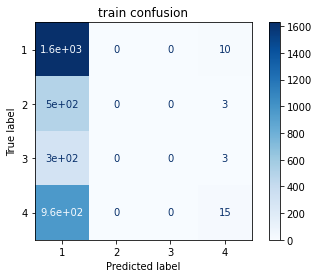

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, lr.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
test_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,541,0,0,5
true 2,165,0,0,2
true 3,100,0,0,0
true 4,320,0,0,6


Text(0.5, 1.0, 'test confusion')

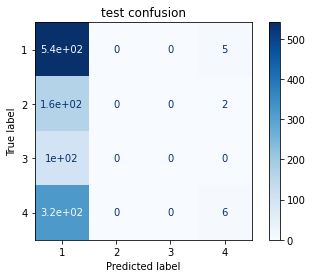

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
lr.classes_

array([1., 2., 3., 4.])

In [ ]:
lr.coef_.shape
  # ndarray of shape (n_classes, n_features)`

(4, 55)

In [ ]:
class_1 = pd.DataFrame(data = lr.coef_[0],index=X_train.columns, columns=['coef'])
class_2 = pd.DataFrame(data = lr.coef_[1],index=X_train.columns, columns=['coef'])
class_3 = pd.DataFrame(data = lr.coef_[2],index=X_train.columns, columns=['coef'])
class_4 = pd.DataFrame(data = lr.coef_[3],index=X_train.columns, columns=['coef'])

In [ ]:
(class_4.sort_values(by='coef',axis=0,ascending=False).tail(10))

,coef
25021-2.0,-0.080433
25886-2.0,-0.080556
25784-2.0,-0.091773
25840-2.0,-0.094587
25783-2.0,-0.100643
25505-2.0,-0.105644
25849-2.0,-0.106166
25785-2.0,-0.138020
25847-2.0,-0.138346
25848-2.0,-0.197074


# multiclass random forest

[here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

## standardizing data

Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.

Random Forest is a tree-based model and hence does not require feature scaling. It will not change the result and even if does, it can only make the results worse. Not only is scaling not necessary, it can smooth out the nonlinear nature of the model. If you have complex nonlinear relationships in p-dimensional space and you have transformed your data, when you back-transform y these nonlinearities are not reflected in the estimate.

reference [here](https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package)

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
rf = RandomForestClassifier(n_estimators=50)

# fit the model to training data (not normalized)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(y_train.iloc[:2])
print(rf.predict(X_train.iloc[:2,:]))

eid
1627366    1.0
5999049    2.0
Name: kmeans_cluster_4, dtype: float64
[1. 2.]


In [ ]:
train_acc = skm.accuracy_score(y_train, rf.predict(X_train))
test_acc = skm.accuracy_score(y_test, rf.predict(X_test))
print(train_acc)
print(test_acc)

1.0
0.45829675153643545


In [ ]:
train_f1 = f1_score(y_train, rf.predict(X_train), average='weighted')
test_f1 = f1_score(y_test, rf.predict(X_test), average='weighted')
print(train_f1)
print(test_f1)

1.0
0.35797035379224085


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train, rf.predict(X_train))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
train_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,1638,0,0,0
true 2,0,501,0,0
true 3,0,0,298,0
true 4,0,0,0,979


Text(0.5, 1.0, 'train confusion')

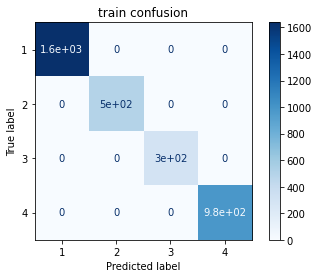

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, rf.predict(X_test))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
test_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,470,2,0,74
true 2,143,1,0,23
true 3,88,1,0,11
true 4,275,0,0,51


Text(0.5, 1.0, 'test confusion')

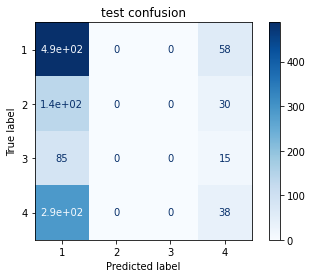

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
rf.classes_

array([1., 2., 3., 4.])

In [ ]:
importances = rf.feature_importances_
importances.shape

(55,)

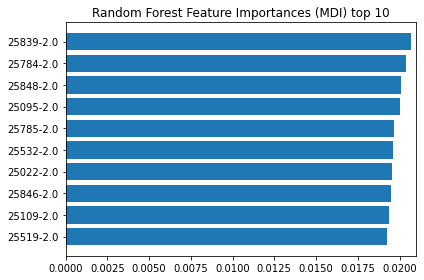

In [ ]:
# plot the top 10 important features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[-n:]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) top 10")
ax.set_xlim(right=0.021)
fig.tight_layout()
plt.show()

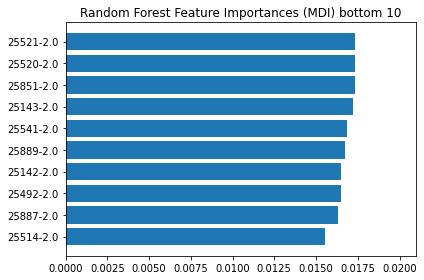

In [ ]:
# plot the bottom 10 useless features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[:n]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) bottom 10")
ax.set_xlim(right=0.021)
fig.tight_layout()
plt.show()

# multiclass knn

[here](https://towardsdatascience.com/knn-in-python-835643e2fb53)

## standardizing data

For KNN, since the metrics are distance based, we must normalize all features. Reference [here](https://www.researchgate.net/post/How_to_perform_normalization_of_data_before_KNN_Imputation#:~:text=For%20classification%20algorithms%20like%20KNN,by%20the%20measurement%20units%20also.&text=To%20avoid%20this%20miss%20classification%2C%20we%20should%20normalize%20the%20feature%20variables).

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we need to standardize our features for the model to work

## model

In [ ]:
# instantiate a model object
knn = KNeighborsClassifier(n_neighbors = 5)  
  # by default, p=2 and metric='minkowski' is euclidean distance
  # try different values of k

# fit the model to training data
knn.fit(X_train_norm,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print(y_train.iloc[0])
print(knn.predict(X_train_norm[0].reshape(1, -1)))

1.0
[1.]


In [ ]:
train_acc = skm.accuracy_score(y_train, knn.predict(X_train_norm))
test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.5843091334894613
0.42493415276558383


In [ ]:
train_f1 = f1_score(y_train, knn.predict(X_train_norm), average='weighted')
test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.5445659472983011
0.36864651817927563


In [ ]:
for i in range(2,16):
  knn = KNeighborsClassifier(n_neighbors = i)
  knn.fit(X_train_norm,y_train)
  train_acc = skm.accuracy_score(y_train, knn.predict(X_train_norm))
  test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
  print(f'i={i}')
  print(train_acc)
  print(test_acc)
  train_f1 = f1_score(y_train, knn.predict(X_train_norm), average='weighted')
  test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
  print(train_f1)
  print(test_f1)
  print(80*'-')

i=2
0.6653981264637002
0.3994732221246708
0.6203793849756282
0.3427913354377137
--------------------------------------------------------------------------------
i=3
0.6267564402810304
0.43459174714661986
0.5930777017189925
0.38232204800735753
--------------------------------------------------------------------------------
i=4
0.5980679156908665
0.42581211589113255
0.5613300887567088
0.3756157324433228
--------------------------------------------------------------------------------
i=5
0.5843091334894613
0.42493415276558383
0.5445659472983011
0.36864651817927563
--------------------------------------------------------------------------------
i=6
0.5702576112412178
0.4266900790166813
0.5177465524665645
0.36399093459190845
--------------------------------------------------------------------------------
i=7
0.5620608899297423
0.43283582089552236
0.5081108599165681
0.3710565443742947
--------------------------------------------------------------------------------
i=8
0.5535714285714286
0.43

## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train, knn.predict(X_train_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
train_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,1492,15,5,126
true 2,389,33,1,78
true 3,231,12,2,53
true 4,683,22,3,271


Text(0.5, 1.0, 'train confusion')

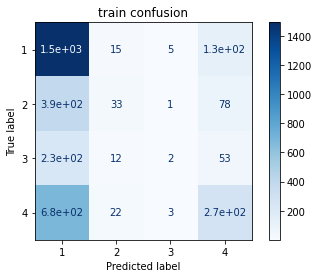

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, knn.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
test_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,457,14,2,73
true 2,134,8,1,24
true 3,77,5,0,18
true 4,258,7,3,58


Text(0.5, 1.0, 'test confusion')

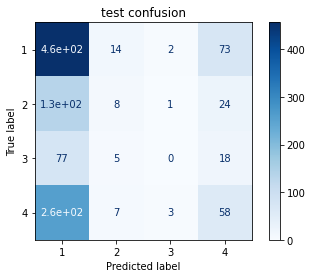

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

KNN does not provide a prediction for the importance or coefficients of variables.

# Re-sampling data - SMOTE

Our data is very imbalanced. We don't have nearly as many samples belonging to classes 2 and 3 as the ones belong to classes 1 and 4. 

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. 

Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or **SMOTE** for short.

View tutorial [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space.

In [ ]:
from imblearn.over_sampling import SMOTE
print(imblearn.__version__)

0.4.3


In [ ]:
y_train.value_counts()

1.0    1638
4.0     979
2.0     501
3.0     298
Name: kmeans_cluster_4, dtype: int64

In [ ]:
# must run all codes until the train test split section is done

# instantiate a SMOTE object
oversamp = SMOTE()

# fit and transform on the training set only!
X_train_smo, y_train_smo = oversamp.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pd.Series(y_train_smo).value_counts()

3.0    1638
4.0    1638
2.0    1638
1.0    1638
dtype: int64

# multiclass logistic regression on SMOTE

[here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

## standardizing data

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_smo_norm = mm.fit_transform(X_train_smo)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
lr = LogisticRegressionCV(cv=5, multi_class='multinomial',max_iter=1000,solver='saga')
  # anything less than 500 do not have enough time to converge

# fit the model to training data
lr.fit(X_train_smo_norm,y_train_smo)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [ ]:
print(y_train_smo[:2])
print(lr.predict(X_train_smo_norm[:2]))

[1. 2.]
[1. 1.]


In [ ]:
train_acc = skm.accuracy_score(y_train_smo, lr.predict(X_train_smo_norm))
test_acc = skm.accuracy_score(y_test, lr.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.3850732600732601
0.305531167690957


In [ ]:
train_f1 = f1_score(y_train_smo, lr.predict(X_train_smo_norm), average='weighted')
test_f1 = f1_score(y_test, lr.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.38151312103936663
0.33154875719041876


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_smo, lr.predict(X_train_smo_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
train_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,636,304,377,321
true 2,349,588,409,292
true 3,294,306,823,215
true 4,412,339,411,476


Text(0.5, 1.0, 'train confusion')

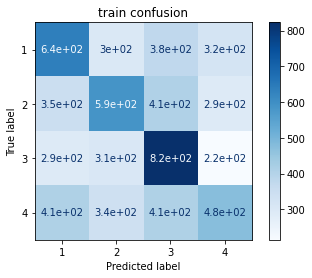

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, lr.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
test_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,198,120,120,108
true 2,46,38,53,30
true 3,24,25,29,22
true 4,99,68,76,83


Text(0.5, 1.0, 'test confusion')

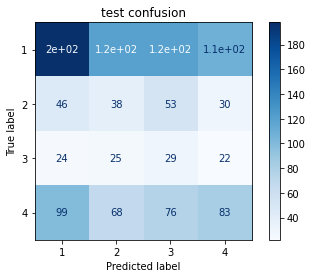

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
lr.classes_

array([1., 2., 3., 4.])

In [ ]:
lr.coef_.shape
  # ndarray of shape (n_classes, n_features)`

(4, 55)

In [ ]:
class_1 = pd.DataFrame(data = lr.coef_[0],index=X_train.columns, columns=['coef'])
class_2 = pd.DataFrame(data = lr.coef_[1],index=X_train.columns, columns=['coef'])
class_3 = pd.DataFrame(data = lr.coef_[2],index=X_train.columns, columns=['coef'])
class_4 = pd.DataFrame(data = lr.coef_[3],index=X_train.columns, columns=['coef'])

In [ ]:
(class_4.sort_values(by='coef',axis=0,ascending=True).head(10))

,coef
25878-2.0,-1.636450
25783-2.0,-1.282479
25848-2.0,-1.074687
25019-2.0,-1.013273
25840-2.0,-0.954471
25505-2.0,-0.690549
25514-2.0,-0.688012
25524-2.0,-0.624188
25022-2.0,-0.552554
25785-2.0,-0.546090


# multiclass random forest on SMOTE

[here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

## standardizing data

Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.

Random Forest is a tree-based model and hence does not require feature scaling. It will not change the result and even if does, it can only make the results worse. Not only is scaling not necessary, it can smooth out the nonlinear nature of the model. If you have complex nonlinear relationships in p-dimensional space and you have transformed your data, when you back-transform y these nonlinearities are not reflected in the estimate.

reference [here](https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package)

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
rf = RandomForestClassifier(n_estimators=50)

# fit the model to training data (not normalized)
rf.fit(X_train_smo,y_train_smo)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(y_train_smo[:2])
print(rf.predict(X_train_smo[:2,:]))

[1. 2.]
[1. 2.]


In [ ]:
train_acc = skm.accuracy_score(y_train_smo, rf.predict(X_train_smo))
test_acc = skm.accuracy_score(y_test, rf.predict(X_test))
print(train_acc)
print(test_acc)

1.0
0.38366988586479367


In [ ]:
train_f1 = f1_score(y_train_smo, rf.predict(X_train_smo), average='weighted')
test_f1 = f1_score(y_test, rf.predict(X_test), average='weighted')
print(train_f1)
print(test_f1)

1.0
0.36485327185801397


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_smo, rf.predict(X_train_smo))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
train_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,1638,0,0,0
true 2,0,1638,0,0
true 3,0,0,1638,0
true 4,0,0,0,1638


Text(0.5, 1.0, 'train confusion')

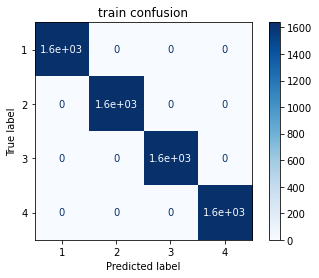

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, rf.predict(X_test))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
test_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,327,56,31,132
true 2,78,27,12,50
true 3,55,13,3,29
true 4,188,33,19,86


Text(0.5, 1.0, 'test confusion')

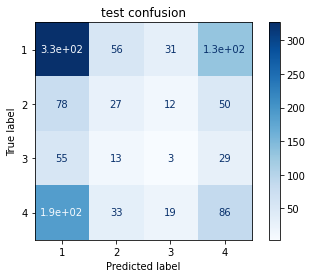

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
rf.classes_

array([1., 2., 3., 4.])

In [ ]:
importances = rf.feature_importances_
importances.shape

(55,)

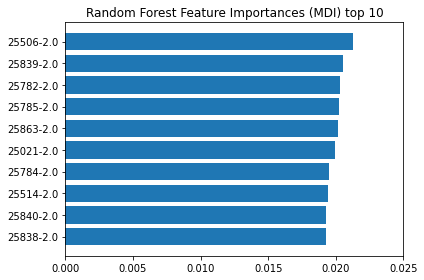

In [ ]:
# plot the top 10 important features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[-n:]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) top 10")
ax.set_xlim(right=0.025)
fig.tight_layout()
plt.show()

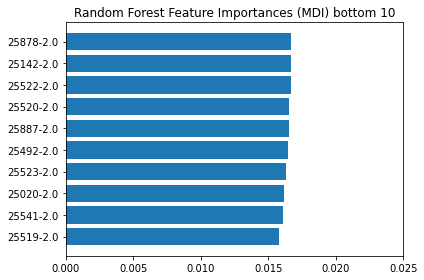

In [ ]:
# plot the bottom 10 useless features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[:n]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) bottom 10")
ax.set_xlim(right=0.025)
fig.tight_layout()
plt.show()

# multiclass knn on SMOTE

[here](https://towardsdatascience.com/knn-in-python-835643e2fb53)

## standardizing data

For KNN, since the metrics are distance based, we must normalize all features. Reference [here](https://www.researchgate.net/post/How_to_perform_normalization_of_data_before_KNN_Imputation#:~:text=For%20classification%20algorithms%20like%20KNN,by%20the%20measurement%20units%20also.&text=To%20avoid%20this%20miss%20classification%2C%20we%20should%20normalize%20the%20feature%20variables).

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_smo_norm = mm.fit_transform(X_train_smo)
X_test_norm = mm.transform(X_test)

# note that we need to standardize our features for the model to work

## model

In [ ]:
# instantiate a model object
knn = KNeighborsClassifier(n_neighbors = 5)  
  # by default, p=2 and metric='minkowski' is euclidean distance
  # try different values of k

# fit the model to training data
knn.fit(X_train_smo_norm,y_train_smo)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print(y_train_smo[0])
print(knn.predict(X_train_smo_norm[0].reshape(1, -1)))

1.0
[1.]


In [ ]:
train_acc = skm.accuracy_score(y_train_smo, knn.predict(X_train_smo_norm))
test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.7448107448107448
0.2177348551360843


In [ ]:
train_f1 = f1_score(y_train_smo, knn.predict(X_train_smo_norm), average='weighted')
test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.71620884797281
0.22633908472609146


In [ ]:
for i in range(2,11):
  knn = KNeighborsClassifier(n_neighbors = i)
  knn.fit(X_train_smo_norm,y_train_smo)
  train_acc = skm.accuracy_score(y_train_smo, knn.predict(X_train_smo_norm))
  test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
  print(f'i={i}')
  print(train_acc)
  print(test_acc)
  train_f1 = f1_score(y_train_smo, knn.predict(X_train_smo_norm), average='weighted')
  test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
  print(train_f1)
  print(test_f1)
  print(80*'-')

i=2
0.9503968253968254
0.247585601404741
0.9486628563777884
0.26564452626513146
--------------------------------------------------------------------------------
i=3
0.8542429792429792
0.2414398595258999
0.8451524354506728
0.257629012470517
--------------------------------------------------------------------------------
i=4
0.7783882783882784
0.218612818261633
0.758357305068205
0.22901788762337483
--------------------------------------------------------------------------------
i=5
0.7448107448107448
0.2177348551360843
0.71620884797281
0.22633908472609146
--------------------------------------------------------------------------------
i=6
0.7155067155067155
0.20632133450395082
0.6823226808096059
0.2113109583780189
--------------------------------------------------------------------------------
i=7
0.6881868131868132
0.20632133450395082
0.646229622795034
0.21120659240574433
--------------------------------------------------------------------------------
i=8
0.6613247863247863
0.2010535557

## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_smo, knn.predict(X_train_smo_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
train_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,1638,0,0,0
true 2,8,1630,0,0
true 3,0,3,1635,0
true 4,81,120,113,1324


Text(0.5, 1.0, 'train confusion')

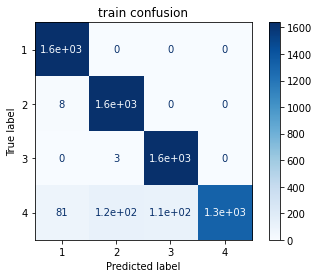

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, knn.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
test_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,147,196,129,74
true 2,34,70,42,21
true 3,31,41,20,8
true 4,86,115,80,45


Text(0.5, 1.0, 'test confusion')

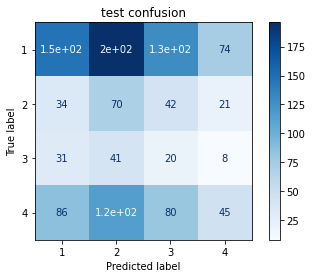

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

KNN does not provide a prediction for the importance or coefficients of variables.

# Re-sampling data - ADASYN

Our data is very imbalanced. We don't have nearly as many samples belonging to classes 2 and 3 as the ones belong to classes 1 and 4. 

Another approach involves generating synthetic samples inversely proportional to the density of the examples in the minority class.

That is, generate more synthetic examples in regions of the feature space where the density of minority examples is low, and fewer or none where the density is high.

This modification to SMOTE is referred to as the Adaptive Synthetic Sampling Method, or ADASYN.

View tutorial [here](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/).

In [ ]:
from imblearn.over_sampling import ADASYN
print(imblearn.__version__)

0.4.3


In [ ]:
y_train.value_counts()

1.0    1638
4.0     979
2.0     501
3.0     298
Name: kmeans_cluster_4, dtype: int64

In [ ]:
# must run all codes until the train test split section is done

# instantiate a ADASYN object
oversamp = ADASYN()

# fit and transform on the training set only!
X_train_ada, y_train_ada = oversamp.fit_resample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pd.Series(y_train_ada).value_counts()

4.0    1814
2.0    1730
3.0    1658
1.0    1638
dtype: int64

# multiclass logistic regression on ADASYN

[here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV)

## standardizing data

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_ada_norm = mm.fit_transform(X_train_ada)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
lr = LogisticRegressionCV(cv=5, multi_class='multinomial',max_iter=1000,solver='saga')
  # anything less than 500 do not have enough time to converge

# fit the model to training data
lr.fit(X_train_ada_norm,y_train_ada)

LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='multinomial', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)

In [ ]:
print(y_train_ada[0])
print(lr.predict(X_train_ada_norm[0].reshape(1, -1)))

1.0
[1.]


In [ ]:
train_acc = skm.accuracy_score(y_train_ada, lr.predict(X_train_ada_norm))
test_acc = skm.accuracy_score(y_test, lr.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.37353801169590645
0.2800702370500439


In [ ]:
train_f1 = f1_score(y_train_ada, lr.predict(X_train_ada_norm), average='weighted')
test_f1 = f1_score(y_test, lr.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.3718798228779027
0.306918117614174


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_ada, lr.predict(X_train_ada_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
train_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,539,335,340,424
true 2,305,590,410,425
true 3,263,335,743,317
true 4,368,390,412,644


Text(0.5, 1.0, 'train confusion')

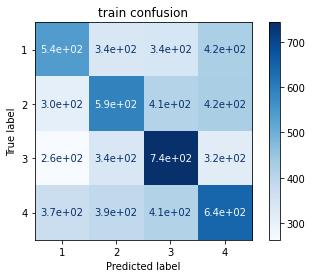

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, lr.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
test_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,162,119,119,146
true 2,37,41,45,44
true 3,20,28,25,27
true 4,85,67,76,98


Text(0.5, 1.0, 'test confusion')

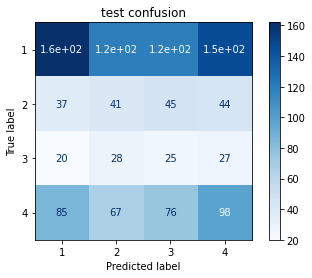

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
lr.classes_

array([1., 2., 3., 4.])

In [ ]:
lr.coef_.shape
  # ndarray of shape (n_classes, n_features)`

(4, 55)

In [ ]:
class_1 = pd.DataFrame(data = lr.coef_[0],index=X_train.columns, columns=['coef'])
class_2 = pd.DataFrame(data = lr.coef_[1],index=X_train.columns, columns=['coef'])
class_3 = pd.DataFrame(data = lr.coef_[2],index=X_train.columns, columns=['coef'])
class_4 = pd.DataFrame(data = lr.coef_[3],index=X_train.columns, columns=['coef'])

In [ ]:
(class_4.sort_values(by='coef',axis=0,ascending=True).head(10))

,coef
25878-2.0,-1.896776
25848-2.0,-1.210803
25785-2.0,-0.941220
25524-2.0,-0.849668
25783-2.0,-0.836490
25886-2.0,-0.798728
25505-2.0,-0.794151
25840-2.0,-0.771332
25019-2.0,-0.703710
25514-2.0,-0.605602


# multiclass random forest on ADASYN

[here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

## standardizing data

Scaling is done to Normalize data so that priority is not given to a particular feature. Role of Scaling is mostly important in algorithms that are distance based and require Euclidean Distance.

Random Forest is a tree-based model and hence does not require feature scaling. It will not change the result and even if does, it can only make the results worse. Not only is scaling not necessary, it can smooth out the nonlinear nature of the model. If you have complex nonlinear relationships in p-dimensional space and you have transformed your data, when you back-transform y these nonlinearities are not reflected in the estimate.

reference [here](https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package)

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_norm = mm.fit_transform(X_train)
X_test_norm = mm.transform(X_test)

# note that we do not need to standardize our features for the model to work
# but if we want to use the coef. values as indicators of feature importance, we must make all features have the same scale

## model

In [ ]:
# instantiate a model object
rf = RandomForestClassifier(n_estimators=50)

# fit the model to training data (not normalized)
rf.fit(X_train_ada,y_train_ada)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print(y_train_ada[:2])
print(rf.predict(X_train_ada[:2,:]))

[1. 2.]
[1. 2.]


In [ ]:
train_acc = skm.accuracy_score(y_train_ada, rf.predict(X_train_ada))
test_acc = skm.accuracy_score(y_test, rf.predict(X_test))
print(train_acc)
print(test_acc)

1.0
0.3713784021071115


In [ ]:
train_f1 = f1_score(y_train_ada, rf.predict(X_train_ada), average='weighted')
test_f1 = f1_score(y_test, rf.predict(X_test), average='weighted')
print(train_f1)
print(test_f1)

1.0
0.35265374674272304


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_ada, rf.predict(X_train_ada))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
train_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,1638,0,0,0
true 2,0,1730,0,0
true 3,0,0,1658,0
true 4,0,0,0,1814


Text(0.5, 1.0, 'train confusion')

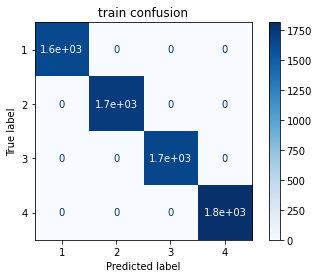

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, rf.predict(X_test))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
test_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,316,70,30,130
true 2,81,20,10,56
true 3,58,6,6,30
true 4,163,40,15,108


Text(0.5, 1.0, 'test confusion')

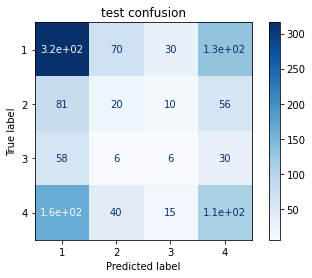

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

In [ ]:
rf.classes_

array([1., 2., 3., 4.])

In [ ]:
importances = rf.feature_importances_
importances.shape

(55,)

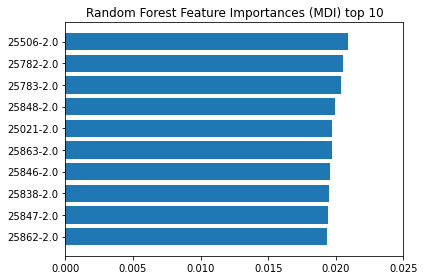

In [ ]:
# plot the top 10 important features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[-n:]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) top 10")
ax.set_xlim(right=0.025)
fig.tight_layout()
plt.show()

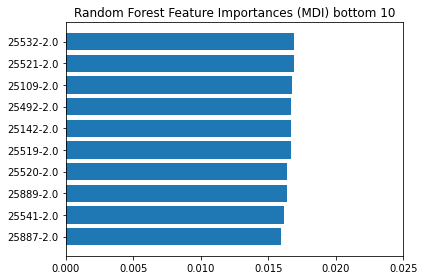

In [ ]:
# plot the bottom 10 useless features
n=10
  # the first n number of important features we are interested in
importances = rf.feature_importances_
indices = np.argsort(importances)[:n]
  # grac the last 10 indices with the highest feature importance

y_ticks = np.arange(0, n)
fig, ax = plt.subplots()
ax.barh(y_ticks, importances[indices])
ax.set_yticklabels(X_train.columns[indices])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI) bottom 10")
ax.set_xlim(right=0.025)
fig.tight_layout()
plt.show()

# multiclass knn on ADASYN

[here](https://towardsdatascience.com/knn-in-python-835643e2fb53)

## standardizing data

For KNN, since the metrics are distance based, we must normalize all features. Reference [here](https://www.researchgate.net/post/How_to_perform_normalization_of_data_before_KNN_Imputation#:~:text=For%20classification%20algorithms%20like%20KNN,by%20the%20measurement%20units%20also.&text=To%20avoid%20this%20miss%20classification%2C%20we%20should%20normalize%20the%20feature%20variables).

In [ ]:
# fit on train only, then transform both train the test
mm = MinMaxScaler()
X_train_ada_norm = mm.fit_transform(X_train_ada)
X_test_norm = mm.transform(X_test)

# note that we need to standardize our features for the model to work

## model

In [ ]:
# instantiate a model object
knn = KNeighborsClassifier(n_neighbors = 5)  
  # by default, p=2 and metric='minkowski' is euclidean distance
  # try different values of k

# fit the model to training data
knn.fit(X_train_ada_norm,y_train_ada)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
print(y_train_ada[0])
print(knn.predict(X_train_ada_norm[0].reshape(1, -1)))

1.0
[1.]


In [ ]:
train_acc = skm.accuracy_score(y_train_ada, knn.predict(X_train_ada_norm))
test_acc = skm.accuracy_score(y_test, knn.predict(X_test_norm))
print(train_acc)
print(test_acc)

0.7653508771929824
0.19754170324846357


In [ ]:
train_f1 = f1_score(y_train_ada, knn.predict(X_train_ada_norm), average='weighted')
test_f1 = f1_score(y_test, knn.predict(X_test_norm), average='weighted')
print(train_f1)
print(test_f1)

0.7344326522594193
0.20671031948301175


## confusion matrix

In [ ]:
train_cm = confusion_matrix(y_train_ada, knn.predict(X_train_ada_norm))
train_cm_df = pd.DataFrame(data=train_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
train_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,509,499,375,255
true 2,7,1710,10,3
true 3,0,1,1657,0
true 4,42,176,214,1382


Text(0.5, 1.0, 'train confusion')

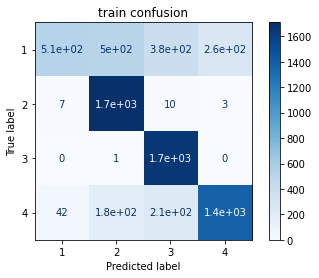

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=train_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('train confusion')

In [ ]:
test_cm = confusion_matrix(y_test, knn.predict(X_test_norm))
test_cm_df = pd.DataFrame(data=test_cm,
                     index=['true 1', 'true 2','true 3','true 4'],
                     columns=['predicted 1', 'predicted 2','predicted 3','predicted 4'])
test_cm_df

,predicted 1,predicted 2,predicted 3,predicted 4
true 1,58,200,169,119
true 2,16,64,46,41
true 3,11,39,30,20
true 4,33,111,106,76


Text(0.5, 1.0, 'test confusion')

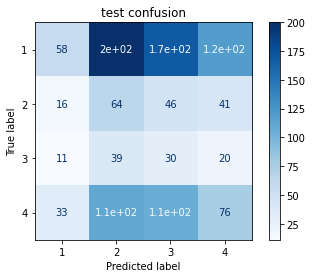

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=[1, 2, 3, 4])
disp.plot(cmap='Blues')
plt.title('test confusion')

## feature importance

KNN does not provide a prediction for the importance or coefficients of variables.